# **imports**

In [6]:
%load_ext autoreload
%autoreload 2

In [316]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
import scipy.signal as sig
import pandas as pd
from itertools import combinations


In [357]:
import os
import sys
sys.path.append("../")

from modules.utils import load_json, get_pooled_IPL_positions, get_template, get_interpolated_templates, get_downsampled_data, get_cone_tunings, get_log_opsin_tunings, get_list_of_colors, get_closest_wavelength, get_layered_weights, get_df_with_ipl_and_regions
from modules.preprocessing import pool_avg_traces, get_baseline_subtracted_traces
from modules.masking import get_masked_traces, get_masked_IPL_positions, get_masked_recorded_regions
from modules.model import fit_model, get_residuals, plot_residuals

In [3]:
plt.rcParams["figure.autolayout"] = True

# **load data**

In [350]:
qc = 0.35 # quality criterion to evaluate traces
std_qc = 1
nLEDs = 6 # number of LEDs used in a given experiment
fpath_expinfo = r'../experiment_info/zf_leds_for_analysis.json'
led_nms = load_json(fpath_expinfo)
led_nms_num = np.array([int(led) for led in led_nms])
cmap_list = get_list_of_colors(nLEDs, red_first=True)

In [18]:
# get average traces
fpath_control = r"D:\Project_with_Chiara\analysis_clean\data\control"
fpath_red = r"D:\Project_with_Chiara\analysis_clean\data\red"
fpath_green = r"D:\Project_with_Chiara\analysis_clean\data\green"
fpath_blue = r"D:\Project_with_Chiara\analysis_clean\data\blue"
fpath_uv = r"D:\Project_with_Chiara\analysis_clean\data\uv"


pooled_traces_control, pooled_triggerstamps_control, pooled_ticks_control, pooled_baselines_control, pooled_quality_criterion_control = pool_avg_traces(fpath_control, fpath_expinfo, nLEDs)
pooled_traces_bs_control = get_baseline_subtracted_traces(pooled_traces_control, pooled_baselines_control, snippets=False)

pooled_traces_red, pooled_triggerstamps_red, pooled_ticks_red, pooled_baselines_red, pooled_quality_criterion_red = pool_avg_traces(fpath_red, fpath_expinfo, nLEDs)
pooled_traces_bs_red = get_baseline_subtracted_traces(pooled_traces_red, pooled_baselines_red, snippets=False)

pooled_traces_green, pooled_triggerstamps_green, pooled_ticks_green, pooled_baselines_green, pooled_quality_criterion_green = pool_avg_traces(fpath_green, fpath_expinfo, nLEDs)
pooled_traces_bs_green = get_baseline_subtracted_traces(pooled_traces_green, pooled_baselines_green, snippets=False)

pooled_traces_blue, pooled_triggerstamps_blue, pooled_ticks_blue, pooled_baselines_blue, pooled_quality_criterion_blue = pool_avg_traces(fpath_blue, fpath_expinfo, nLEDs)
pooled_traces_bs_blue = get_baseline_subtracted_traces(pooled_traces_blue, pooled_baselines_blue, snippets=False)

pooled_traces_uv, pooled_triggerstamps_uv, pooled_ticks_uv, pooled_baselines_uv, pooled_quality_criterion_uv = pool_avg_traces(fpath_uv, fpath_expinfo, nLEDs)
pooled_traces_bs_uv = get_baseline_subtracted_traces(pooled_traces_uv, pooled_baselines_uv, snippets=False)

14it [00:09,  1.41it/s]


final shape of pooled traces: 1917 rois | 18000  time points


15it [00:09,  1.58it/s]


final shape of pooled traces: 2238 rois | 18000  time points


8it [00:04,  1.84it/s]


final shape of pooled traces: 1039 rois | 18000  time points


9it [00:04,  1.95it/s]


final shape of pooled traces: 1045 rois | 18000  time points


14it [00:09,  1.46it/s]

final shape of pooled traces: 2058 rois | 18000  time points


In [17]:
# get the IPL positions and the regions of the rois
pooled_IPLs_control, pooled_regions_control = get_pooled_IPL_positions(fpath_control)
pooled_IPLs_uv, pooled_regions_uv = get_pooled_IPL_positions(fpath_uv)
pooled_IPLs_green, pooled_regions_green = get_pooled_IPL_positions(fpath_green)
pooled_IPLs_red, pooled_regions_red = get_pooled_IPL_positions(fpath_red)
pooled_IPLs_blue, pooled_regions_blue = get_pooled_IPL_positions(fpath_blue)

0it [00:00, ?it/s]

final shape of pooled IPL positions: 1917 rois


0it [00:00, ?it/s]

final shape of pooled IPL positions: 2058 rois


0it [00:00, ?it/s]

final shape of pooled IPL positions: 1039 rois


0it [00:00, ?it/s]

final shape of pooled IPL positions: 2238 rois


0it [00:00, ?it/s]

final shape of pooled IPL positions: 1045 rois


# **template matching**

## **get templates**

In [135]:
# get the template
ticks_per_template = 200
path_to_template = r"..\experiment_info\model\fitting_templates.mat"
templates = get_template(path_to_template, temp_type='3s')
templates = get_interpolated_templates(templates, num_of_ds_ticks=ticks_per_template)

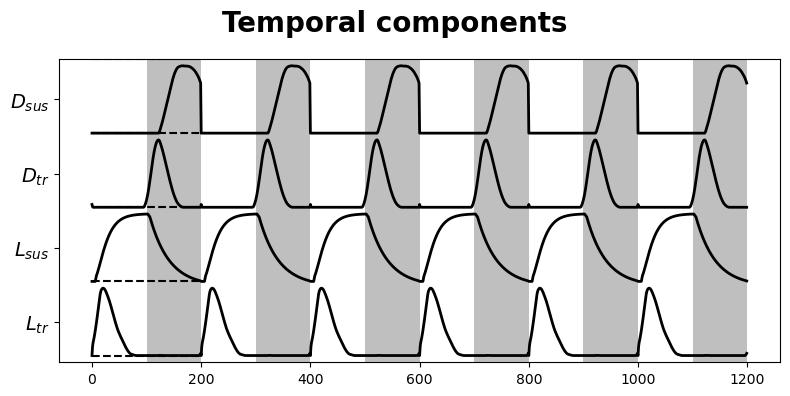

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
temp_labels = [r'$L_{tr}$', r'$L_{sus}$', r'$D_{tr}$', r'$D_{sus}$']
fig.suptitle('Temporal components', fontsize=20, fontweight='bold')
expand_templates = np.zeros((nLEDs*templates.shape[0], templates.shape[1]))
for i in range(nLEDs):
    expand_templates[i*templates.shape[0]:(i+1)*templates.shape[0]] = templates
    
    
for i in range(templates.shape[1]):
    ax.plot(expand_templates[:, i] + i*1.1, 'k', lw=2)
# ax.vlines(100, -0.1, 4.1, ls='--', lw = 2, color='k')
for i in range(nLEDs):
    ax.axvspan(ticks_per_template*i+ticks_per_template/2, ticks_per_template*i+ticks_per_template, 0, 4.1, facecolor='gray', alpha=0.5)
    ax.hlines(i*1.1, 0, templates.shape[0], 'k', '--')

ax.yaxis.set_ticks([i*1.1+0.5 for i in range(templates.shape[1])], temp_labels, fontsize=14)
ax.set_ylim(-0.1, 4.4)
plt.tight_layout()

## **downsample traces**

In [341]:
# downsample data
ticks_to_interpolate = ticks_per_template * nLEDs
traces_ds_control = get_downsampled_data(pooled_traces_bs_control, ticks_to_interpolate)
traces_ds_uv = get_downsampled_data(pooled_traces_bs_uv, ticks_to_interpolate)
traces_ds_green = get_downsampled_data(pooled_traces_bs_green, ticks_to_interpolate)
traces_ds_red = get_downsampled_data(pooled_traces_bs_red, ticks_to_interpolate)
traces_ds_blue = get_downsampled_data(pooled_traces_bs_blue, ticks_to_interpolate)

In [342]:
# mask data
traces_ds_control = get_masked_traces(traces_ds_control, pooled_quality_criterion_control, qc=qc, ipl_positions=pooled_IPLs_control, std_qc=std_qc)
traces_ds_uv = get_masked_traces(traces_ds_uv, pooled_quality_criterion_uv, qc=qc, ipl_positions=pooled_IPLs_uv, std_qc=std_qc)
traces_ds_green = get_masked_traces(traces_ds_green, pooled_quality_criterion_green, qc=qc, ipl_positions=pooled_IPLs_green, std_qc=std_qc)
traces_ds_red = get_masked_traces(traces_ds_red, pooled_quality_criterion_red, qc=qc, ipl_positions=pooled_IPLs_red, std_qc=std_qc)
traces_ds_blue = get_masked_traces(traces_ds_blue, pooled_quality_criterion_blue, qc=qc, ipl_positions=pooled_IPLs_blue, std_qc=std_qc)

In [347]:
pooled_IPL_control_masked = get_masked_IPL_positions(pooled_IPLs_control, traces_ds_control, pooled_quality_criterion_control, qc=qc, std_qc=std_qc)
pooled_IPL_red_masked = get_masked_IPL_positions(pooled_IPLs_red, traces_ds_red, pooled_quality_criterion_red, qc=qc, std_qc=std_qc)
pooled_IPL_blue_masked = get_masked_IPL_positions(pooled_IPLs_blue, traces_ds_blue, pooled_quality_criterion_blue, qc=qc, std_qc=std_qc)
pooled_IPL_green_masked = get_masked_IPL_positions(pooled_IPLs_green, traces_ds_green, pooled_quality_criterion_green, qc=qc, std_qc=std_qc)
pooled_IPL_uv_masked = get_masked_IPL_positions(pooled_IPLs_uv, traces_ds_uv, pooled_quality_criterion_uv, qc=qc, std_qc=std_qc)

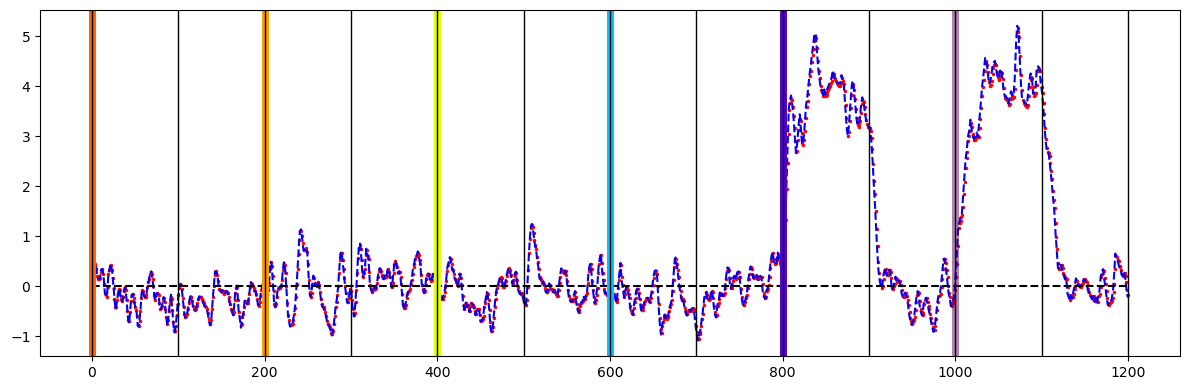

In [351]:
roi = 200
N = ticks_per_template * nLEDs
ticks = int(N / (nLEDs))

t = np.linspace(0, N, pooled_traces_bs_control.shape[1])
t_ds = np.linspace(0, N, traces_ds_control.shape[1])

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(t_ds, traces_ds_control[roi, :], 'r.', label="downsampled data", markersize=3)
ax.plot(t, pooled_traces_bs_control[roi, :], 'b--', label="raw data", markersize=3)
ax.hlines(0, 0, N, 'k', '--')
for i in range(nLEDs):
    ax.axvline((i*ticks), c = cmap_list[i], lw = 5)
for i in range(2*nLEDs+1):
    ax.axvline((i*ticks/2), c = 'k', lw = 1)


## **get cone tuning curves**

In [178]:
path_to_cone_data = r"..\experiment_info\model\cone_data.csv"
cone_tunings, cone_tuning_columns = get_cone_tunings(path_to_cone_data, N_ticks_extra=templates.shape[0])

## **get log opsin tuning curves**

In [179]:
log_opsin_tuning, opsins = get_log_opsin_tunings()

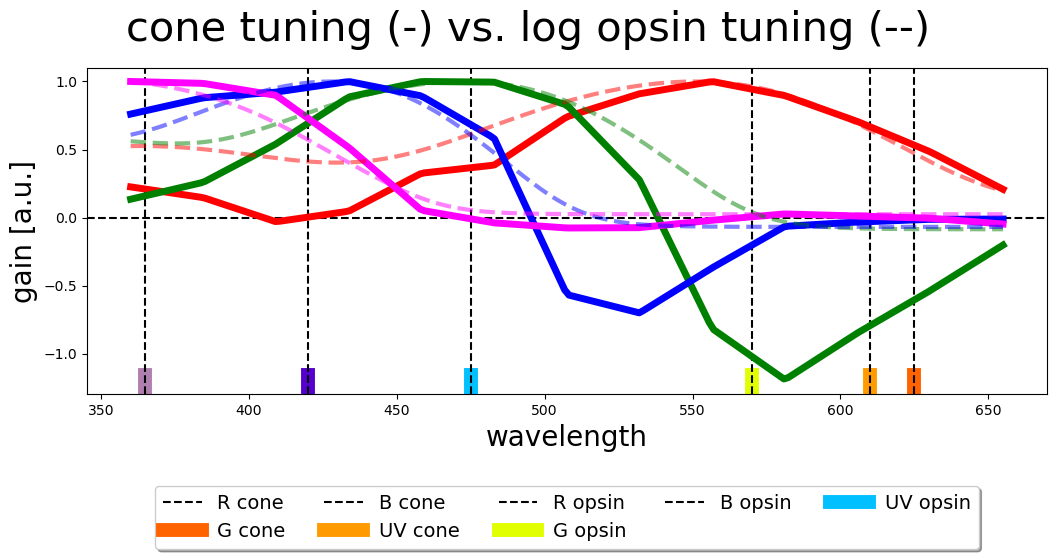

In [180]:
aspect_ratio = 1920 / 1080
height = 6
fig, ax = plt.subplots(1, 1, figsize=(height*aspect_ratio, height))
legend_labels = ['R cone', 'G cone', 'B cone', 'UV cone', 'R opsin', 'G opsin', 'B opsin', 'UV opsin']

fig.suptitle("cone tuning (-) vs. log opsin tuning (--)", fontsize=30)
ax.axhline(y=0, color='k', linestyle='--')

ax.set_ylabel('gain [a.u.]', fontsize=20)
ax.set_ylim(-1.3, 1.1)
fig.gca().set_xlabel(r'$\lambda$ [nm]', fontsize=20)
# ax.set_xlabel('wavelength [nm]', fontsize=20)

for id, led in enumerate(led_nms_num):
    ax.axvline(led, ymin=0, ymax=.06, c = cmap_list[id], lw = 10)
    ax.axvline(led, c='k', ls='--')

cone_tunings.plot(x="wavelength", y=cone_tuning_columns[1:], color=['r', 'g', 'b', 'magenta'], style='-', linewidth=5, legend=True, ax=ax)
log_opsin_tuning.plot(x='wavelength', y=opsins, color=['r', 'g', 'b', 'magenta'], style='--', legend=True, linewidth=3, alpha=0.5, ax=ax)
ax.legend(legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=5, fontsize=14)
plt.tight_layout()


## **get spectral components for each template**

In [186]:
temp_columns = ['Ltr_red', 'Ltr_green', 'Ltr_blue', 'Ltr_uv',
                'Lsus_red', 'Lsus_green', 'Lsus_blue', 'Lsus_uv',
                'Dtr_red', 'Dtr_green', 'Dtr_blue', 'Dtr_uv',
                'Dsus_red', 'Dsus_green', 'Dsus_blue', 'Dsus_uv']

# create an empty array to hold the interpolated templates: temporal components weighted by gains of each cone for a given LED wavelength
cone_templates_control = np.zeros((ticks_to_interpolate, len(temp_columns)))

'''get templates for control data'''
# for each LED
for led, nm in enumerate(led_nms):
      # get idx of the closest wavelength [nm] from interpolated cone tunings
      idx = get_closest_wavelength(cone_tunings['wavelength'], float(nm))
      
      # print the closest wavelength and its corresponding gains
      print('idx: ', idx, 'nm: ', nm, 'wv: ', cone_tunings['wavelength'].iloc[idx], 'nm |', 'red gain:', 
            cone_tunings['Red'].iloc[idx], "| green gain:", cone_tunings['Green'].iloc[idx], "| blue gain:", 
            cone_tunings['Blue'].iloc[idx], "| uv gain:", cone_tunings['UV'].iloc[idx])

      # get weights = gains of each cone type for a given LED wavelength
      # there are 4 types of templates: [Ltr, Lsus, Dtr, Dsus] that repeat for each LED -> 4x4 weights in total
      weights = cone_tunings[cone_tuning_columns[1:]].iloc[idx].to_numpy()

      for temp_type in range(4):
            template_broadcasted = np.broadcast_to(templates[:, temp_type, np.newaxis], (templates.shape[0], weights.shape[0])).copy()
            weighted_templates = template_broadcasted * weights
            cone_templates_control[led*200:(led+1)*200, temp_type*4:(temp_type+1)*4:] = weighted_templates
      
'''get templates for 'ablated' data'''
ablated_components_red = ['Ltr_red', 'Lsus_red', 'Dtr_red', 'Dsus_red']
ablated_components_green = ['Ltr_green', 'Lsus_green', 'Dtr_green', 'Dsus_green']
ablated_components_blue = ['Ltr_blue', 'Lsus_blue', 'Dtr_blue', 'Dsus_blue']
ablated_components_uv = ['Ltr_uv', 'Lsus_uv', 'Dtr_uv', 'Dsus_uv']
# red ablated

cone_templates_red = pd.DataFrame(cone_templates_control.copy(), columns=temp_columns)
cone_templates_red[ablated_components_red] = 0 # kill red cone components
# red ablation modifies the green and blue cone components, so we need to update the red cone templates
for led, nm in enumerate(led_nms):
      # get idx of the closest wavelength [nm] from interpolated log opsin tunings
      idx = get_closest_wavelength(log_opsin_tuning['wavelength'], float(nm))
      
      # print the closest wavelength and its corresponding gains
      print('log opsin idx: ', idx, 'nm: ', nm, 'wv: ', log_opsin_tuning['wavelength'].iloc[idx], 'nm |', 'red gain:', 
            log_opsin_tuning['R'].iloc[idx], "| green gain:", log_opsin_tuning['G'].iloc[idx], "| blue gain:", 
            log_opsin_tuning['B'].iloc[idx], "| uv gain:", log_opsin_tuning['U'].iloc[idx])

      # get weight = gain of red cone for a given LED wavelength
      for cone_type_, ablated_components_ in zip(['G', 'B'], [ablated_components_green, ablated_components_blue]):
            weight = log_opsin_tuning[cone_type_].iloc[idx]
            weighted_templates = templates * weight
            cone_templates_red.loc[led*200:(led+1)*200-1, ablated_components_] = weighted_templates
cone_templates_red = cone_templates_red.to_numpy()

# green ablated
cone_templates_green = pd.DataFrame(cone_templates_control.copy(), columns=temp_columns)
cone_templates_green[ablated_components_green] = 0 # kill green cone components
cone_templates_green = cone_templates_green.to_numpy()

# blue ablated
cone_templates_blue = pd.DataFrame(cone_templates_control.copy(), columns=temp_columns)
cone_templates_blue[ablated_components_blue] = 0 # kill blue cone components
cone_templates_blue = cone_templates_blue.to_numpy()

# uv ablated
cone_templates_uv = pd.DataFrame(cone_templates_control.copy(), columns=temp_columns)
cone_templates_uv[ablated_components_uv] = 0 # kill uv cone components
# UV ablation modifies the red cone components, so we need to update the red cone templates
for led, nm in enumerate(led_nms):
      # get idx of the closest wavelength [nm] from interpolated log opsin tunings
      idx = get_closest_wavelength(log_opsin_tuning['wavelength'], float(nm))
      
      # print the closest wavelength and its corresponding gains
      print('log opsin idx: ', idx, 'nm: ', nm, 'wv: ', log_opsin_tuning['wavelength'].iloc[idx], 'nm |', 'red gain:', 
            log_opsin_tuning['R'].iloc[idx], "| green gain:", log_opsin_tuning['G'].iloc[idx], "| blue gain:", 
            log_opsin_tuning['B'].iloc[idx], "| uv gain:", log_opsin_tuning['U'].iloc[idx])

      # get weight = gain of red cone for a given LED wavelength
      weight = log_opsin_tuning['R'].iloc[idx]
      weighted_templates = templates * weight
      cone_templates_uv.loc[led*200:(led+1)*200-1, ablated_components_red] = weighted_templates
cone_templates_uv = cone_templates_uv.to_numpy()


idx:  20 nm:  625 wv:  625.3517587939698 nm | red gain: 0.5284241557788948 | green gain: -0.6008514974874376 | blue gain: -0.017150774874371888 | uv gain: -0.001718048341708519
idx:  30 nm:  610 wv:  610.5276381909548 nm | red gain: 0.6628597336683417 | green gain: -0.7885212462311557 | blue gain: -0.029168262311557783 | uv gain: 0.008168317487437182
idx:  57 nm:  570 wv:  570.5025125628141 nm | red gain: 0.9414448241206028 | green gain: -1.0280811608040208 | blue gain: -0.19807583417085364 | uv gain: 0.006337903517588037
idx:  121 nm:  475 wv:  475.6281407035176 nm | red gain: 0.36745426130653264 | green gain: 0.9966927638190956 | blue gain: 0.6754564170854273 | uv gain: -0.011780287939698458
idx:  159 nm:  420 wv:  419.2964824120603 nm | red gain: 0.0007014316582914168 | green gain: 0.6829966834170853 | blue gain: 0.9539602060301507 | uv gain: 0.7401965728643218
idx:  196 nm:  365 wv:  364.4472361809045 nm | red gain: 0.2107909648241207 | green gain: 0.15701161306532646 | blue gain: 

## **fit templates**

In [189]:
fit_responses_control, weights_control = fit_model(traces_ds_control, cone_templates_control)
fit_responses_uv, weights_uv = fit_model(traces_ds_uv, cone_templates_uv)
fit_responses_green, weights_green = fit_model(traces_ds_green, cone_templates_green)
fit_responses_red, weights_red = fit_model(traces_ds_red, cone_templates_red)
fit_responses_blue, weights_blue = fit_model(traces_ds_blue, cone_templates_blue)

## **plot residuals**

In [194]:
control_color = 'k'
uv_color = 'magenta'
green_color = 'g'
red_color = 'r'
blue_color = 'b'

markersize_led = 10
control_alpha = 0.5
uv_alpha = 0.6
green_alpha = 0.6
red_alpha = 0.6
blue_alpha = 0.6

In [192]:
residuals_control, traces_compressed_control, fits_compressed_control = get_residuals(fit_responses_control, traces_ds_control)
residuals_red, traces_compressed_red, fits_compressed_red = get_residuals(fit_responses_red, traces_ds_red)
residuals_green, traces_compressed_green, fits_compressed_green = get_residuals(fit_responses_green, traces_ds_green)
residuals_blue, traces_compressed_blue, fits_compressed_blue = get_residuals(fit_responses_blue, traces_ds_blue)
residuals_uv, traces_compressed_uv, fits_compressed_uv = get_residuals(fit_responses_uv, traces_ds_uv)

In [361]:
# save = False
# plot_residuals(traces_compressed_control, fits_compressed_control, residuals_control, ticks_per_template, nLEDs, cmap_list, control_color, control_alpha, 'control', save)
# plot_residuals(traces_compressed_uv, fits_compressed_uv, residuals_uv, ticks_per_template, nLEDs, cmap_list, uv_color, uv_alpha, 'uv', save)
# plot_residuals(traces_compressed_green, fits_compressed_green, residuals_green, ticks_per_template, nLEDs, cmap_list, green_color, green_alpha, 'green', save)
# plot_residuals(traces_compressed_red, fits_compressed_red, residuals_red, ticks_per_template, nLEDs, cmap_list, red_color, red_alpha, 'red', save)
# plot_residuals(traces_compressed_blue, fits_compressed_blue, residuals_blue, ticks_per_template, nLEDs, cmap_list, blue_color, blue_alpha, 'blue', save)

# **group ROIs and associated weights by IPL positions**

## **prepare weights**

In [303]:
control_labels = ['control' for i in range(weights_control.shape[0])]
uv_labels = ['uv' for i in range(weights_uv.shape[0])]
green_labels = ['green' for i in range(weights_green.shape[0])]
red_labels = ['red' for i in range(weights_red.shape[0])]
blue_labels = ['blue' for i in range(weights_blue.shape[0])]

concat_labels = control_labels + uv_labels + green_labels + red_labels + blue_labels
concat_weights = np.concatenate((weights_control, weights_uv, weights_green, weights_red, weights_blue), axis=0)
concat_masks = np.concatenate((~weights_control.mask[:, 0], ~weights_uv.mask[:, 0], ~weights_green.mask[:, 0], ~weights_red.mask[:, 0], ~weights_blue.mask[:, 0]), axis=0)
concat_ipls = np.concatenate((pooled_IPLs_control_masked, pooled_IPLs_uv_masked, pooled_IPLs_green_masked, pooled_IPLs_red_masked, pooled_IPLs_blue_masked), axis=0)

weights_df = pd.DataFrame(concat_weights, columns=temp_columns)
weights_df['IPL'] = concat_ipls
weights_df['condition'] = concat_labels
weights_df['valid'] = concat_masks
weights_df = weights_df.drop(weights_df[weights_df.valid == False].index)
weights_df = weights_df.drop(['valid'], axis=1)

In [301]:
weights_df

,Ltr_red,Ltr_green,Ltr_blue,Ltr_uv,Lsus_red,Lsus_green,Lsus_blue,Lsus_uv,Dtr_red,Dtr_green,Dtr_blue,Dtr_uv,Dsus_red,Dsus_green,Dsus_blue,Dsus_uv,IPL,condition
3,0.614043,1.800754,-2.412200e+00,0.706741,0.602032,1.850995,-3.152914e+00,1.101832,0.816733,-0.288506,1.119406,0.200672,0.610935,0.506368,-0.816956,0.542608,85.0,control
5,0.757542,1.128250,-2.046192e+00,1.055574,0.365563,0.980630,-1.140762e+00,0.044772,-0.596970,-0.522082,0.099290,0.149457,-0.369387,0.306226,-0.810395,0.124788,22.0,control
21,0.986125,0.514291,-6.561195e-02,0.226429,1.854306,1.087107,-6.907859e-01,0.845925,0.058597,-0.875133,1.815206,-0.717214,1.248847,-0.002194,0.866561,0.138535,94.0,control
30,1.764210,2.214821,-3.423774e+00,1.882008,0.095827,0.683813,-7.768020e-01,0.043383,1.074170,-0.837410,2.124761,-0.488706,0.564708,0.259937,0.199230,-0.300358,79.0,control
35,1.303884,2.007944,-3.233219e+00,1.548907,0.445827,0.996105,-1.151644e+00,0.081482,0.421941,-2.085140,5.053403,-2.157772,0.905275,0.416094,-0.439118,0.662647,78.0,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8292,3.964150,1.834370,-2.664535e-15,13.374758,2.409001,1.710541,0.000000e+00,18.153497,-2.427603,-1.449698,0.000000,-5.644795,-3.591120,-1.093161,0.000000,-1.484916,13.0,blue
8293,6.073997,2.800824,-3.552714e-15,14.274676,-0.625327,0.168266,8.881784e-16,11.879286,-1.254315,-0.510042,0.000000,-7.041742,-1.492314,-0.770990,0.000000,-0.740399,30.0,blue
8294,2.177177,1.355943,2.220446e-16,0.702864,2.585613,1.130865,1.110223e-15,0.637122,3.074771,1.072763,0.000000,1.350626,-0.086818,0.116717,0.000000,-0.009175,83.0,blue
8295,5.117903,2.926778,-4.440892e-15,15.722203,4.899073,2.511269,0.000000e+00,11.939570,-1.763647,-0.730490,0.000000,-4.354087,-2.734184,-0.818936,0.000000,-1.305075,69.0,blue


In [305]:
step_size = 1
ws_ipl_means_control, ws_ipl_std_control, ws_ipl_num_cells_control, interval = get_layered_weights(weights_df[weights_df['condition'] == 'control'], step_size)
ws_ipl_means_uv, ws_ipl_std_uv, ws_ipl_num_cells_uv, _ = get_layered_weights(weights_df[weights_df['condition'] == 'uv'], step_size)
ws_ipl_means_green, ws_ipl_std_green, ws_ipl_num_cells_green, _ = get_layered_weights(weights_df[weights_df['condition'] == 'green'], step_size)
ws_ipl_means_red, ws_ipl_std_red, ws_ipl_num_cells_red, _ = get_layered_weights(weights_df[weights_df['condition'] == 'red'], step_size)
ws_ipl_means_blue, ws_ipl_std_blue, ws_ipl_num_cells_blue, _ = get_layered_weights(weights_df[weights_df['condition'] == 'blue'], step_size)
ws_ipl_means_concat = np.concatenate((ws_ipl_means_control, ws_ipl_means_uv, ws_ipl_means_green, ws_ipl_means_red, ws_ipl_means_blue), axis=0)

control_labels = ['control' for i in range(ws_ipl_means_control.shape[0])]
uv_labels = ['uv' for i in range(ws_ipl_means_uv.shape[0])]
green_labels = ['green' for i in range(ws_ipl_means_green.shape[0])]
red_labels = ['red' for i in range(ws_ipl_means_red.shape[0])]
blue_labels = ['blue' for i in range(ws_ipl_means_blue.shape[0])]
concat_labels = control_labels + uv_labels + green_labels + red_labels + blue_labels

ws_ipl_means_df = pd.DataFrame(ws_ipl_means_concat, columns=temp_columns)
ws_ipl_means_df['condition'] = concat_labels

## **plot weights across IPLs**

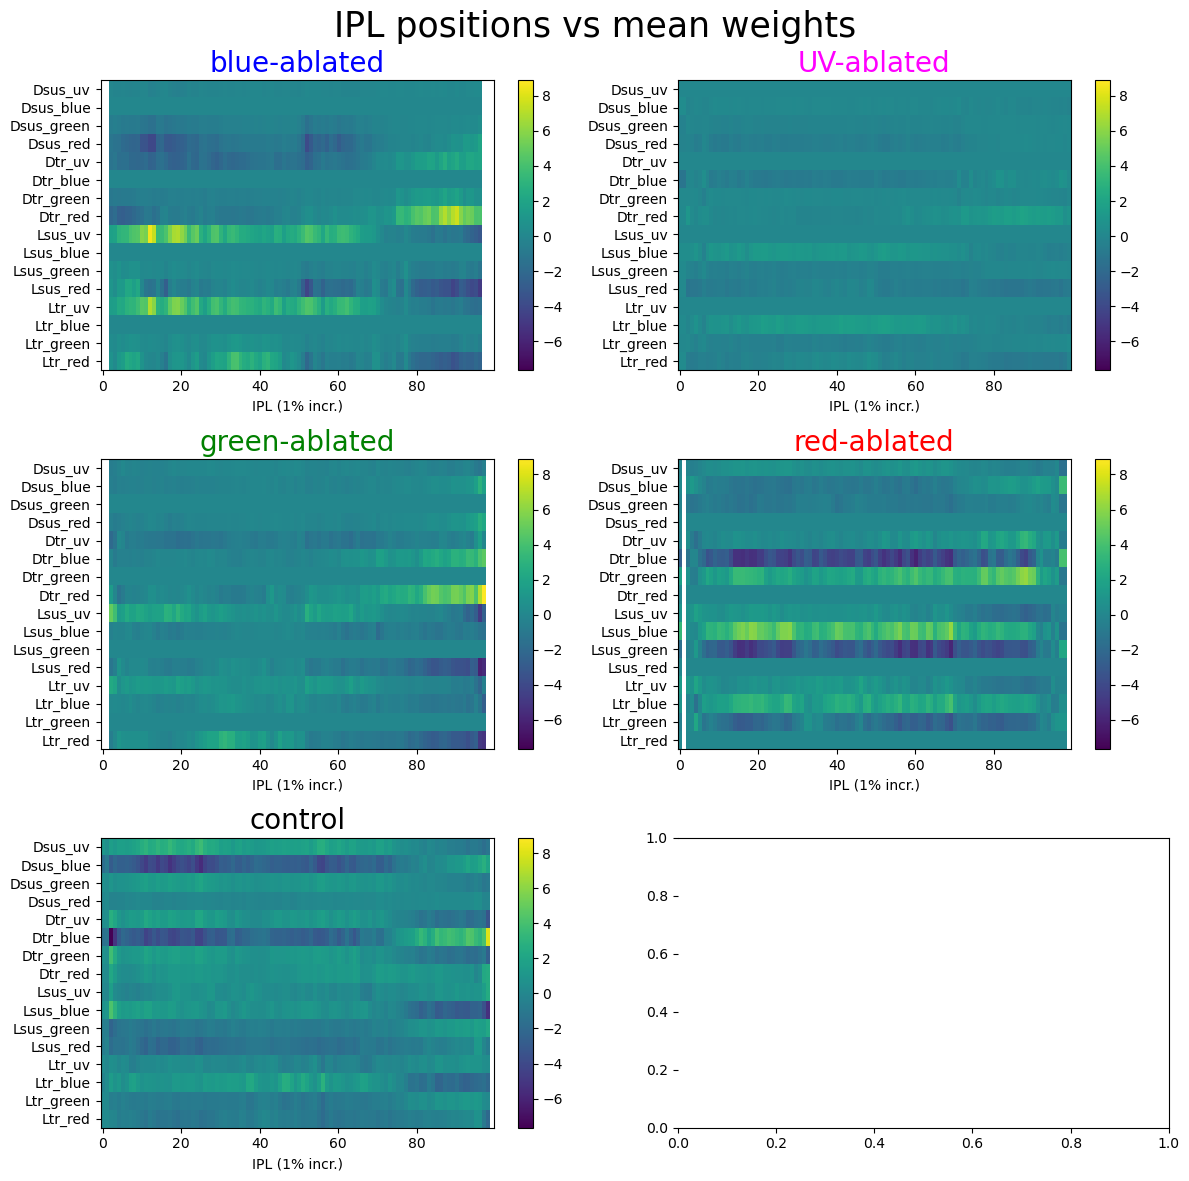

In [307]:
temp_columns = ['Ltr_red', 'Ltr_green', 'Ltr_blue', 'Ltr_uv',
                'Lsus_red', 'Lsus_green', 'Lsus_blue', 'Lsus_uv',
                'Dtr_red', 'Dtr_green', 'Dtr_blue', 'Dtr_uv',
                'Dsus_red', 'Dsus_green', 'Dsus_blue', 'Dsus_uv']
cmap_list = get_list_of_colors(nLEDs, red_first=True)
num = 1

to_plot = (ws_ipl_means_control, ws_ipl_means_uv, ws_ipl_means_green, ws_ipl_means_red, ws_ipl_means_blue)

ylim_min = np.nanmin((np.nanmin(ws_ipl_means_control), np.nanmin(ws_ipl_means_uv), np.nanmin(ws_ipl_means_green), np.nanmin(ws_ipl_means_red), np.nanmin(ws_ipl_means_blue)))
ylim_max = np.nanmax((np.nanmax(ws_ipl_means_control), np.nanmax(ws_ipl_means_uv), np.nanmax(ws_ipl_means_green), np.nanmax(ws_ipl_means_red), np.nanmax(ws_ipl_means_blue)))

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

stims = nLEDs
n_components = 16
ticks = int(n_components / (nLEDs))
# --------------------------------------------------------------
r_control = 2
im1 = axs[r_control, 0].imshow(to_plot[0].T, aspect = "auto", cmap = "viridis", vmin=ylim_min, vmax=ylim_max, origin = "lower", interpolation="None")
axs[r_control, 0].set_xlabel(f"IPL ({interval[num][1] - interval[num][0]}% incr.)")
axs[r_control, 0].set_title("control", fontsize = 20, color='k')
plt.gca().spines["left"].set_visible(False)
axs[r_control, 0].set_yticks(np.arange(len(temp_columns)), labels=temp_columns)

fig.colorbar(im1, ax=axs[r_control, 0])
# --------------------------------------------------------------    
im2 =axs[0, 1].imshow(to_plot[1].T, aspect = "auto", cmap = "viridis", vmin=ylim_min, vmax=ylim_max, origin = "lower", interpolation="None")
axs[0, 1].set_xlabel(f"IPL ({interval[num][1] - interval[num][0]}% incr.)")
axs[0, 1].set_title("UV-ablated", fontsize = 20, color='magenta')
axs[0, 1].set_yticks(np.arange(len(temp_columns)), labels=temp_columns)
plt.gca().spines["left"].set_visible(False)

fig.colorbar(im2, ax=axs[0, 1])
# # --------------------------------------------------------------
im3 = axs[1, 0].imshow(to_plot[2].T, aspect = "auto", cmap = "viridis", vmin=ylim_min, vmax=ylim_max, origin = "lower", interpolation="None")
axs[1, 0].set_xlabel(f"IPL ({interval[num][1] - interval[num][0]}% incr.)")
axs[1, 0].set_title("green-ablated", fontsize = 20, color='green')
plt.gca().spines["left"].set_visible(False)

axs[1, 0].set_yticks(np.arange(len(temp_columns)), labels=temp_columns)
fig.colorbar(im3, ax=axs[1, 0])
# --------------------------------------------------------------
im4 = axs[1, 1].imshow(to_plot[3].T, aspect = "auto", cmap = "viridis", vmin=ylim_min, vmax=ylim_max, origin = "lower", interpolation="None")
axs[1, 1].set_xlabel(f"IPL ({interval[num][1] - interval[num][0]}% incr.)")
axs[1, 1].set_title("red-ablated", fontsize = 20, color='red')
plt.gca().spines["left"].set_visible(False)

axs[1, 1].set_yticks(np.arange(len(temp_columns)), labels=temp_columns)
fig.colorbar(im4, ax=axs[1, 1])
# --------------------------------------------------------------
r_blue = 0
im4 = axs[r_blue, 0].imshow(to_plot[4].T, aspect = "auto", cmap = "viridis", vmin=ylim_min, vmax=ylim_max, origin = "lower", interpolation="None")
axs[r_blue, 0].set_xlabel(f"IPL ({interval[num][1] - interval[num][0]}% incr.)")
axs[r_blue, 0].set_title("blue-ablated", fontsize = 20, color='blue')
plt.gca().spines["left"].set_visible(False)

axs[r_blue, 0].set_yticks(np.arange(len(temp_columns)), labels=temp_columns)
fig.colorbar(im4, ax=axs[r_blue, 0])
# --------------------------------------------------------------
plt.suptitle("IPL positions vs mean weights", fontsize = 25, color = 'k')

plt.tight_layout()

# **big-picture analysis of weights**

## **prepare weights**

In [308]:
temporal_inputs = [['Ltr_red', 'Ltr_green', 'Ltr_blue', 'Ltr_uv'],
                 ['Lsus_red', 'Lsus_green', 'Lsus_blue', 'Lsus_uv'],
                 ['Dtr_red', 'Dtr_green', 'Dtr_blue', 'Dtr_uv'],
                 ['Dsus_red', 'Dsus_green', 'Dsus_blue', 'Dsus_uv']]
spectral_inputs = [['Ltr_red', 'Lsus_red', 'Dtr_red', 'Dsus_red'],
                   ['Ltr_green', 'Lsus_green', 'Dtr_green', 'Dsus_green'],
                   ['Ltr_blue', 'Lsus_blue', 'Dtr_blue', 'Dsus_blue'],
                   ['Ltr_uv', 'Lsus_uv', 'Dtr_uv', 'Dsus_uv']]

# summed_temporal_inputs_red = weights_df[weights_df['condition'] == 'control'][temporal_inputs[0]].sum(axis=1)
summed_spectral_inputs_control = []
summed_spectral_inputs_red = []
summed_spectral_inputs_green = []
summed_spectral_inputs_blue = []
summed_spectral_inputs_uv = []
for cone in spectral_inputs:
    summed_spectral_inputs_control.append(weights_df[weights_df['condition'] == 'control'][cone].sum(axis=1))
    summed_spectral_inputs_red.append(weights_df[weights_df['condition'] == 'red'][cone].sum(axis=1))
    summed_spectral_inputs_green.append(weights_df[weights_df['condition'] == 'green'][cone].sum(axis=1))
    summed_spectral_inputs_blue.append(weights_df[weights_df['condition'] == 'blue'][cone].sum(axis=1))
    summed_spectral_inputs_uv.append(weights_df[weights_df['condition'] == 'uv'][cone].sum(axis=1))

spectral_columns = {0: 'red', 1: 'green', 2: 'blue', 3: 'uv'}
summed_spectral_inputs_control = pd.DataFrame(summed_spectral_inputs_control).T.rename(columns=spectral_columns)
summed_spectral_inputs_red = pd.DataFrame(summed_spectral_inputs_red).T.rename(columns=spectral_columns)
summed_spectral_inputs_green = pd.DataFrame(summed_spectral_inputs_green).T.rename(columns=spectral_columns)
summed_spectral_inputs_blue = pd.DataFrame(summed_spectral_inputs_blue).T.rename(columns=spectral_columns)
summed_spectral_inputs_uv = pd.DataFrame(summed_spectral_inputs_uv).T.rename(columns=spectral_columns)

summed_temporal_inputs_control = []
summed_temporal_inputs_red = []
summed_temporal_inputs_green = []
summed_temporal_inputs_blue = []
summed_temporal_inputs_uv = []
for temp in temporal_inputs:
    summed_temporal_inputs_control.append(weights_df[weights_df['condition'] == 'control'][temp].sum(axis=1))
    summed_temporal_inputs_red.append(weights_df[weights_df['condition'] == 'red'][temp].sum(axis=1))
    summed_temporal_inputs_green.append(weights_df[weights_df['condition'] == 'green'][temp].sum(axis=1))
    summed_temporal_inputs_blue.append(weights_df[weights_df['condition'] == 'blue'][temp].sum(axis=1))
    summed_temporal_inputs_uv.append(weights_df[weights_df['condition'] == 'uv'][temp].sum(axis=1))
    
temporal_columns = {0: 'Ltr', 1: 'Lsus', 2: 'Dtr', 3: 'Dsus'}
summed_temporal_inputs_control = pd.DataFrame(summed_temporal_inputs_control).T.rename(columns=temporal_columns)
summed_temporal_inputs_red = pd.DataFrame(summed_temporal_inputs_red).T.rename(columns=temporal_columns)
summed_temporal_inputs_green = pd.DataFrame(summed_temporal_inputs_green).T.rename(columns=temporal_columns)
summed_temporal_inputs_blue = pd.DataFrame(summed_temporal_inputs_blue).T.rename(columns=temporal_columns)
summed_temporal_inputs_uv = pd.DataFrame(summed_temporal_inputs_uv).T.rename(columns=temporal_columns)

## **plot summed temporal weights**

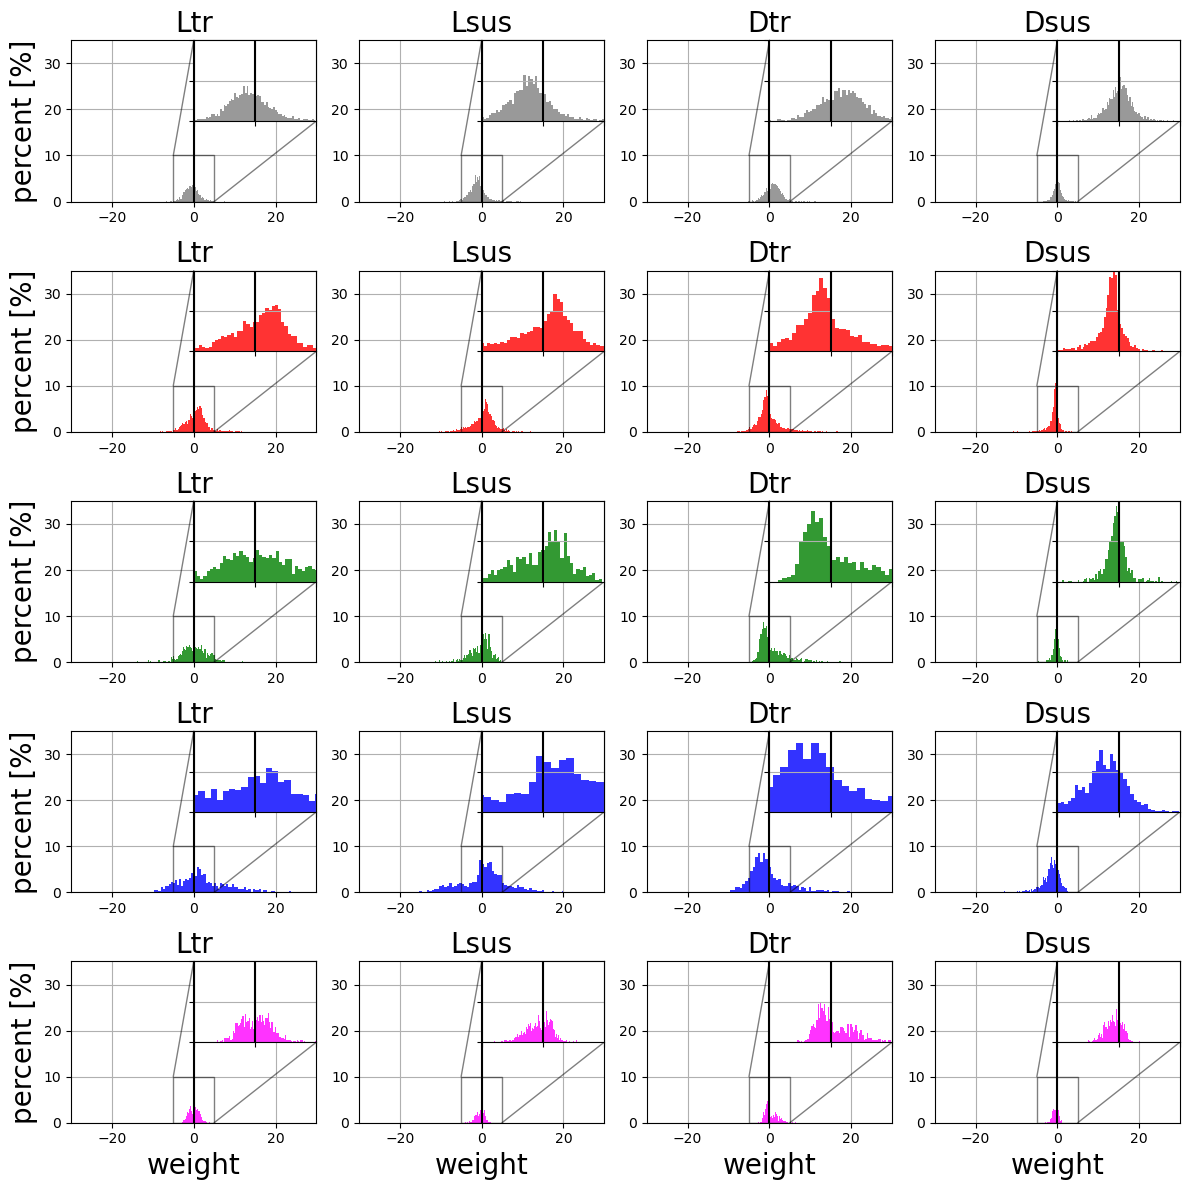

In [310]:
cmap_list = ['gray', 'red', 'green', 'blue', 'magenta']

conditions = ['control', 'red', 'green', 'blue', 'uv']
bins = 100
fontsize = 20
to_plot = [summed_temporal_inputs_control, summed_temporal_inputs_red, summed_temporal_inputs_green, summed_temporal_inputs_blue, summed_temporal_inputs_uv]

fig, axes = plt.subplots(len(conditions), 4, figsize=(12, 12))
for ax in axes.flat:
    ax.axvline(0, color='k')
    
    ax.set_ylim(0, 35)
    ax.set_xlim(-30, 30)
for i, condition in enumerate(conditions):
    df = to_plot[i]
    for j, column in enumerate(df.columns):
        df[column].hist(bins=bins, weights=np.ones_like(df[column]) * 100. / len(df[column]), ax=axes[i, j], color=cmap_list[i], alpha=0.8)
        axes[i, j].set_title(column, fontsize=fontsize)
        if [i, j] in [[0, 0], [1, 0], [2, 0], [3, 0], [4, 0]]:
            axes[i, j].set_ylabel('percent [%]', fontsize=fontsize)
        if [i, j] in [[4, 0], [4, 1], [4, 2], [4, 3], [4, 4]]:
            axes[i, j].set_xlabel('weight', fontsize=fontsize) 

x1, x2, y1, y2 = -5, 5, 0, 10
for i, condition in enumerate(conditions):
    df = to_plot[i]
    for j, column in enumerate(df.columns):
        ax_in_uvdtr = axes[i, j].inset_axes([0.5, 0.5, 0.5, 0.5],
                                    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
        df[column].hist(bins=bins, weights=np.ones_like(df[column]) * 100. / len(df[column]), ax=ax_in_uvdtr, color=cmap_list[i], alpha=0.8)
        ax_in_uvdtr.axvline(0, color='k')
        axes[i, j].indicate_inset_zoom(ax_in_uvdtr, edgecolor="black")

## **plot summed spectral weights**

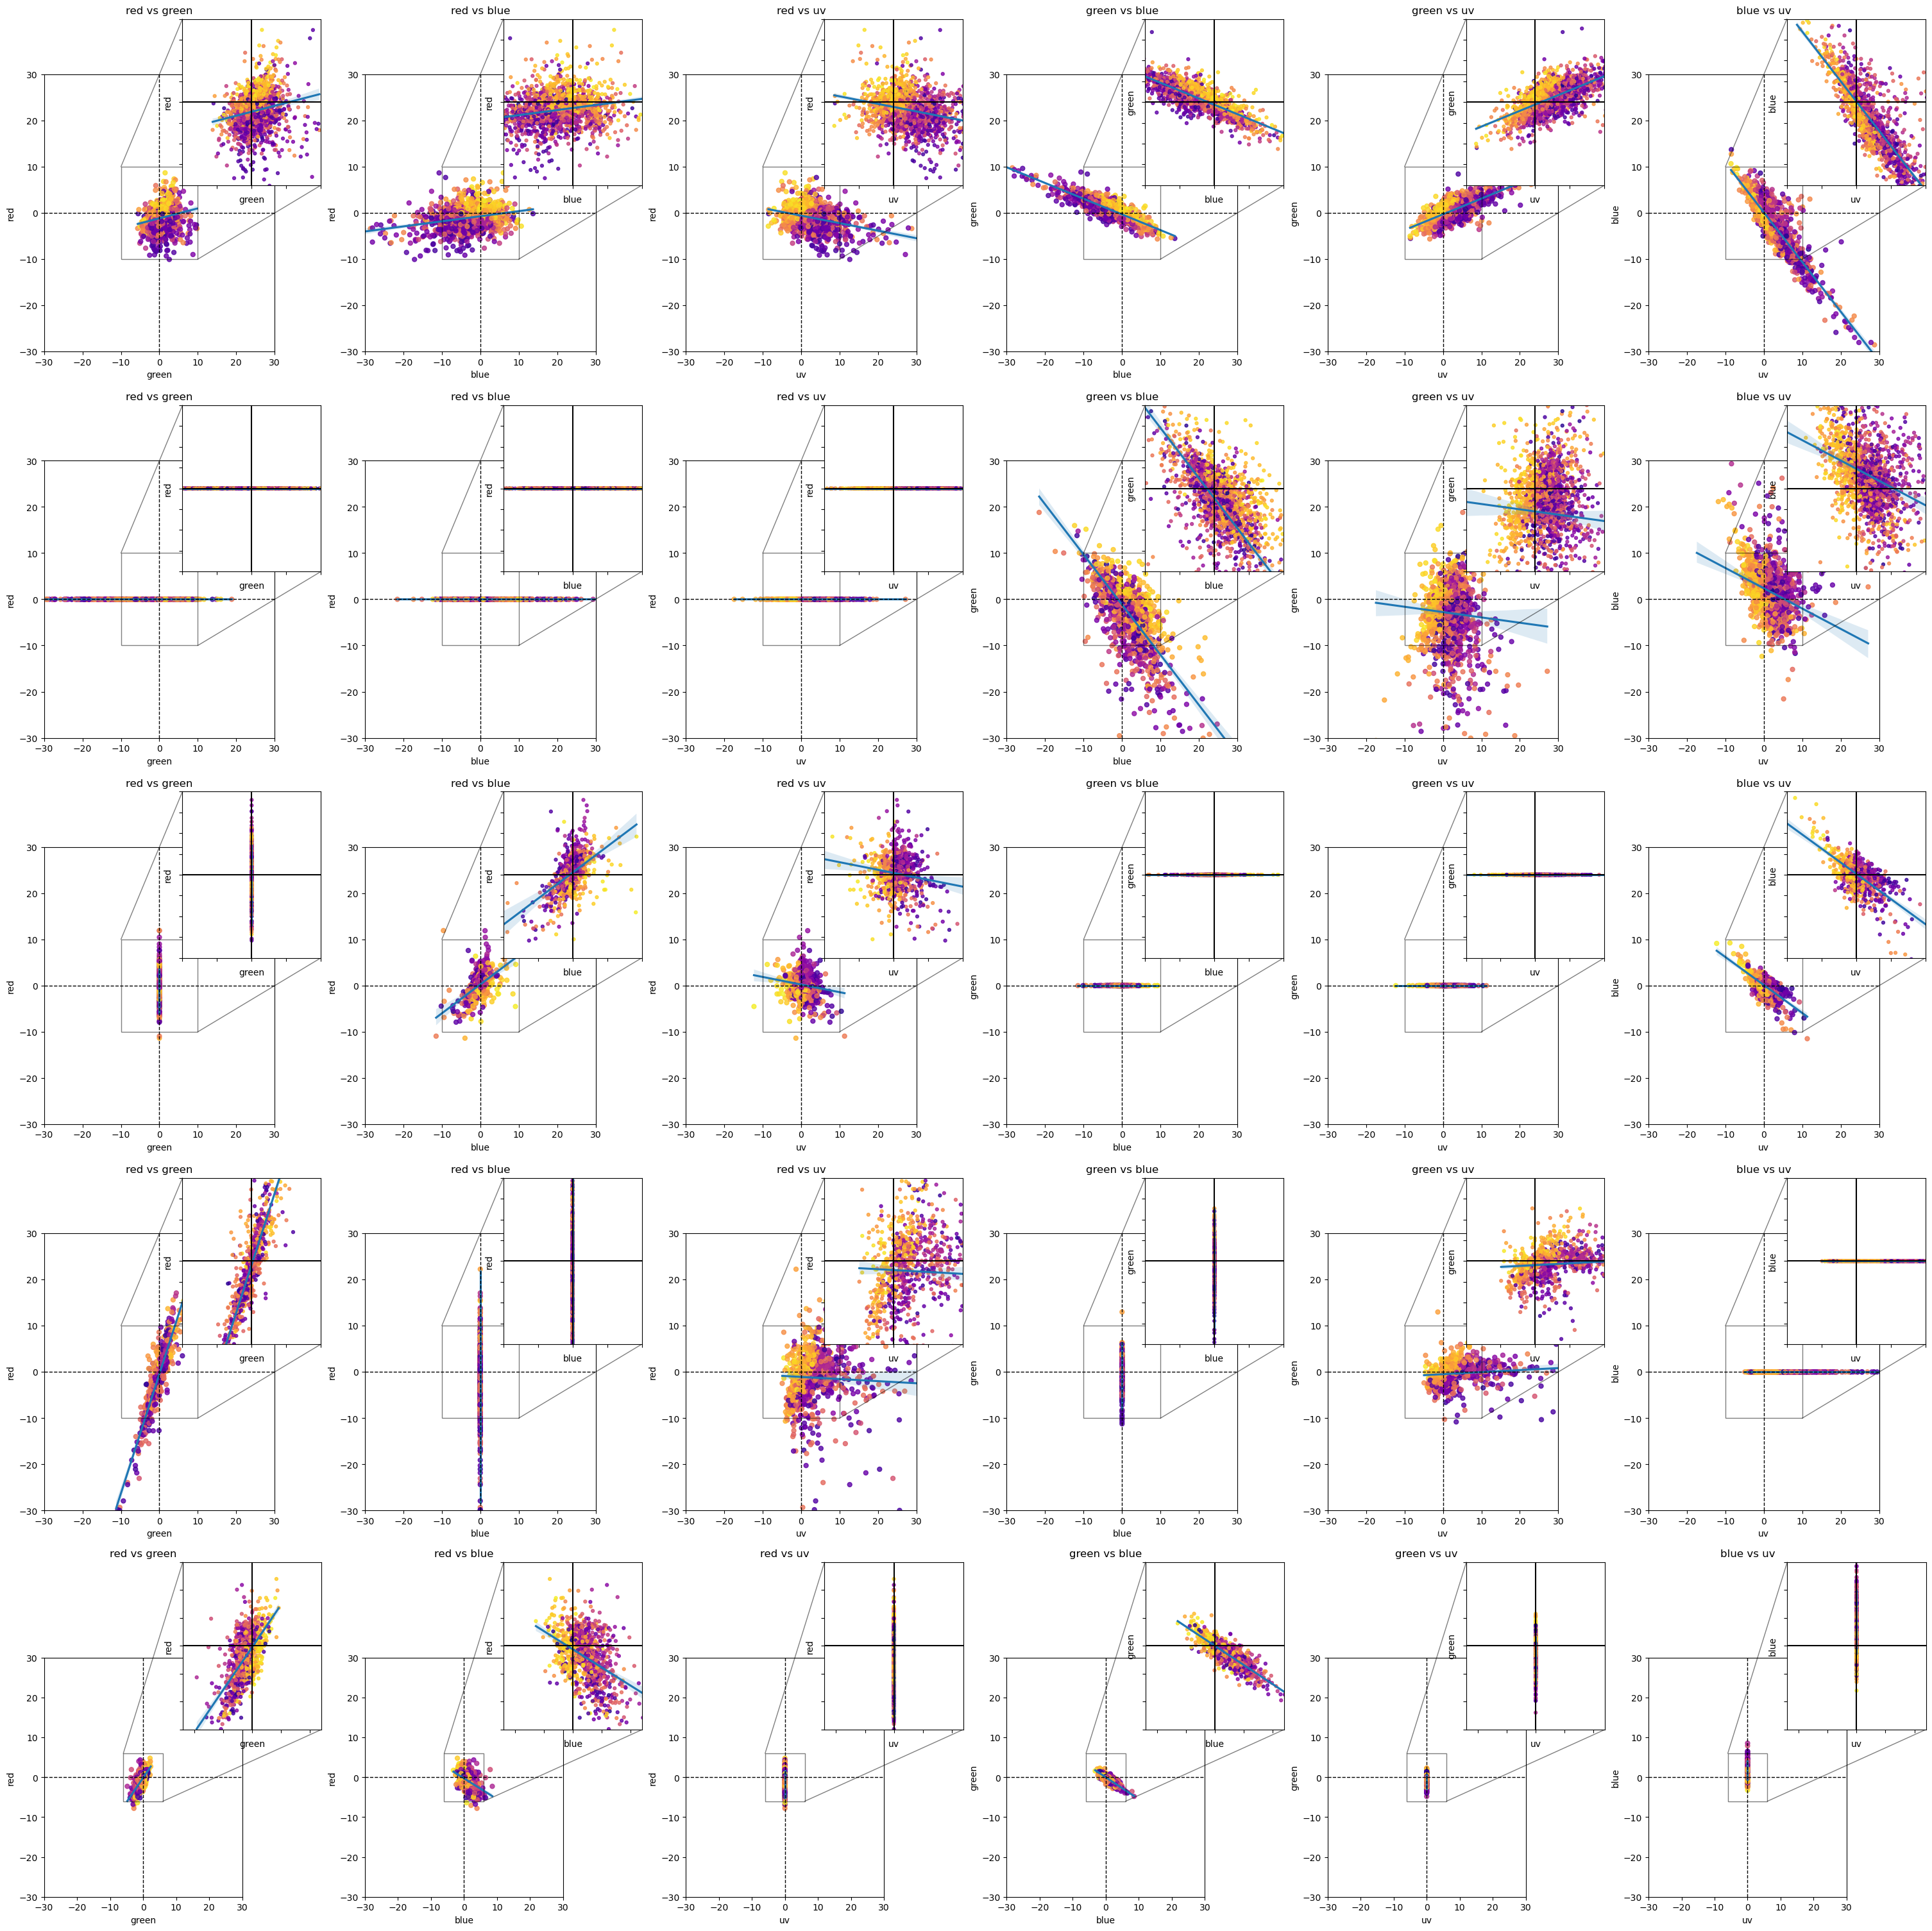

In [317]:
cmap_list = ['gray', 'red', 'green', 'blue', 'magenta']

conditions = ['red', 'green', 'blue', 'uv']
to_plot = [summed_spectral_inputs_control, summed_spectral_inputs_red, summed_spectral_inputs_green, summed_spectral_inputs_blue, summed_spectral_inputs_uv]

ipl_cmap = colormaps['plasma'].resampled(100).colors
marker_size = 100
exp_conditions = ['control', 'red', 'green', 'blue', 'uv']
exp_colors = ['k', 'magenta', 'g', 'r', 'b']
n_conditions = len(exp_conditions)
n_weights = 4
cols = [0, 1, 4, 5, 8, 9, 12, 13]
lims = 8
combs = list(combinations(conditions, 2))
fig = plt.figure(constrained_layout=True, figsize=(30, 30))
subfigs = fig.subfigures(nrows=n_conditions, ncols=1)

lims = 30
for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=len(combs))
    cmap = []
    for roi in range(to_plot[row].shape[0]):
        ipl_val = int(weights_df[weights_df['condition'] == exp_conditions[row]]['IPL'].iloc[roi])
        if ipl_val < 100:
           cmap.append(ipl_cmap[int(weights_df[weights_df['condition'] == exp_conditions[row]]['IPL'].iloc[roi])])
        else:
            cmap.append(ipl_cmap[-1])
    
    df = to_plot[row]
    for col, ax in enumerate(axs):
        if row == 4:
                x1, x2, y1, y2 = -6, 6, -6, 6
                sns.regplot(to_plot[row], y=combs[col][0], x=combs[col][1],
                        ax=ax, marker='.', scatter=True, scatter_kws=dict(color=cmap, s=marker_size))
                ax.axhline(0, color='k', ls='--', lw=1)
                ax.axvline(0, color='k', ls='--', lw=1)
                ax.set(xlim=(-lims, lims), ylim=(-lims, lims))
                ax_in_uvdtr = ax.inset_axes([0.7, 0.7, 0.7, 0.7],
                                        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
                sns.regplot(to_plot[row], y=combs[col][0], x=combs[col][1],
                        ax=ax_in_uvdtr, marker='.', scatter=True, scatter_kws=dict(color=cmap, s=marker_size/2))
                ax_in_uvdtr.axvline(0, color='k')
                ax_in_uvdtr.axhline(0, color='k')
                ax.indicate_inset_zoom(ax_in_uvdtr, edgecolor="black")
                plt.grid()
                ax.set_title("{}".format(combs[col][0] + " vs " + combs[col][1]))
        else:
                x1, x2, y1, y2 = -10, 10, -10, 10
                sns.regplot(to_plot[row], y=combs[col][0], x=combs[col][1],
                        ax=ax, marker='.', scatter=True, scatter_kws=dict(color=cmap, s=marker_size))
                ax.axhline(0, color='k', ls='--', lw=1)
                ax.axvline(0, color='k', ls='--', lw=1)
                ax.set(xlim=(-lims, lims), ylim=(-lims, lims))
                ax_in_uvdtr = ax.inset_axes([0.6, 0.6, 0.6, 0.6],
                                        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
                sns.regplot(to_plot[row], y=combs[col][0], x=combs[col][1],
                        ax=ax_in_uvdtr, marker='.', scatter=True, scatter_kws=dict(color=cmap, s=marker_size/2))
                ax_in_uvdtr.axvline(0, color='k')
                ax_in_uvdtr.axhline(0, color='k')
                ax.indicate_inset_zoom(ax_in_uvdtr, edgecolor="black")
                plt.grid()
                ax.set_title("{}".format(combs[col][0] + " vs " + combs[col][1]))

# **some data summary**

In [354]:
pooled_regions_masked_control = get_masked_recorded_regions(pooled_regions_control, pooled_IPLs_control, 
                                                            traces_ds_control, pooled_quality_criterion_control, qc=qc, std_qc=std_qc)
pooled_regions_masked_red = get_masked_recorded_regions(pooled_regions_red, pooled_IPLs_red,
                                                        traces_ds_red, pooled_quality_criterion_red, qc=qc, std_qc=std_qc)
pooled_regions_masked_blue = get_masked_recorded_regions(pooled_regions_blue, pooled_IPLs_blue,
                                                          traces_ds_blue, pooled_quality_criterion_blue, qc=qc, std_qc=std_qc)
pooled_regions_masked_green = get_masked_recorded_regions(pooled_regions_green, pooled_IPLs_green,
                                                          traces_ds_green, pooled_quality_criterion_green, qc=qc, std_qc=std_qc)
pooled_regions_masked_uv = get_masked_recorded_regions(pooled_regions_uv, pooled_IPLs_uv,
                                                       traces_ds_uv, pooled_quality_criterion_uv, qc=qc, std_qc=std_qc)

In [358]:
anatomical_info_control = get_df_with_ipl_and_regions(pooled_IPLs_control_masked, pooled_regions_masked_control, 'control')
anatomical_info_uv = get_df_with_ipl_and_regions(pooled_IPLs_uv_masked, pooled_regions_masked_uv, 'uv')
anatomical_info_green = get_df_with_ipl_and_regions(pooled_IPLs_green_masked, pooled_regions_masked_green, 'green')
anatomical_info_red = get_df_with_ipl_and_regions(pooled_IPLs_red_masked, pooled_regions_masked_red, 'red')
anatomical_info_blue = get_df_with_ipl_and_regions(pooled_IPLs_blue_masked, pooled_regions_masked_blue, 'blue')
anatomical_info_all = pd.concat([anatomical_info_control, anatomical_info_uv, anatomical_info_green, anatomical_info_red, anatomical_info_blue])

In [359]:
# # fig, ax_cat = plt.subplots(1, 1, figsize=(10, 5))

# # cat = sns.catplot(
# #     data=anatomical_info_all, x='region', col='condition', kind='count'
# # )
# with sns.axes_style("whitegrid"):
#     sns.set_context("talk")
#     sns.set_theme(font_scale=1)
#     g = sns.FacetGrid(anatomical_info_all, col="condition", col_order=['control', 'red', 'green', 'blue', 'uv']) # palette=['gray', 'red', 'green', 'magenta', 'blue']
#     g.map(sns.countplot, "region", order=anatomical_info_all['region'].value_counts().index)
#     g.set_ylabels('count')

In [360]:

# with sns.axes_style("whitegrid"):
#     sns.set_context("talk")
#     sns.set_theme(font_scale=1)
#     g = sns.FacetGrid(anatomical_info_all, col="condition", col_order=['control', 'red', 'green', 'blue', 'uv'])
#     g.map(sns.histplot, "IPL", stat='percent')
#     g.set_ylabels('percent [%]')
#     g.set_xlabels('IPL position [%]')